## Energy Demand Forecast for ERCOT Coast Zone


### Modeling

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import os
import ast
import itertools
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

In [2]:
df = pd.read_csv(os.getcwd() + '/data/ercot_&_weather.csv', parse_dates=['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_convert('US/Central')
df = df.set_index('timestamp').sort_index()

df.head()

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT,temperature_2m,...,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00-06:00,9890.09,1364.28,3721.97,773.88,11719.86,2707.84,5473.25,1172.94,36824.12,10.1,...,79.0,99.0,0.0,0.0,0.0,0.0,5.6,14.0,195.0,198.0
2020-01-01 02:00:00-06:00,9751.59,1369.57,3735.51,775.06,11639.46,2706.84,5387.38,1165.95,36531.37,10.2,...,92.0,100.0,0.0,0.0,0.0,0.0,5.3,13.9,208.0,205.0
2020-01-01 03:00:00-06:00,9603.42,1373.53,3735.85,774.15,11515.42,2650.38,5270.33,1149.08,36072.17,11.1,...,98.0,100.0,0.0,0.0,0.0,0.0,3.9,10.9,214.0,207.0
2020-01-01 04:00:00-06:00,9501.59,1365.63,3743.52,778.10,11518.36,2586.71,5200.96,1141.30,35836.16,11.2,...,99.0,98.0,0.0,0.0,0.0,0.0,3.5,8.4,294.0,260.0
2020-01-01 05:00:00-06:00,9499.43,1385.60,3753.90,784.08,11649.29,2548.85,5230.30,1147.09,35998.54,11.2,...,65.0,100.0,0.0,0.0,0.0,0.0,2.7,2.5,23.0,315.0


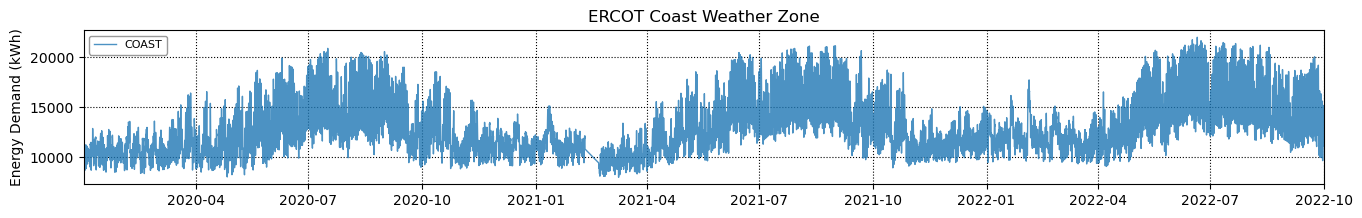

In [3]:
fig, ax = plt.subplots(figsize=(16, 2))
ax.plot(df['COAST'], linewidth=1, c='tab:blue', alpha=0.8, label=f'COAST')
ax.legend(edgecolor='gray', facecolor='white', fontsize=8, loc='upper left')
ax.set_xlim(df.index.min(), df.index.max(), )
ax.set_ylabel('Energy Demand (kWh)')
ax.set_title('ERCOT Coast Weather Zone')

#plt.tight_layout()
plt.show()

### Feature Engineering

In [4]:
# CDH & HDH
df['temp**2'] = df['temperature_2m']**2
set_point = 18.333
df['HDH'] =  (set_point - df['temperature_2m']).clip(0)
df['CDH'] = (df['temperature_2m'] - set_point).clip(0)
df['HDH**2'] = df['HDH']**2
df['CDH**2'] = df['CDH']**2
df['temp**2'] = df['temperature_2m']**2

# lag temperature
lags = [1, 2, 3, 4, 5, 24, 48, 72]
temp_lags = [df[['temperature_2m']].shift(periods=lag).rename(columns={'temperature_2m':f'temp_lag_{lag}'}) for lag in lags]
temp_lags = pd.concat(temp_lags, axis=1)
df = pd.merge(df, temp_lags, left_index=True, right_index=True).dropna()

# lag demand
lags = [1, 3, 5, 24, 36, 48, 72, 168]
load_lags = [df[['COAST']].shift(periods=lag).rename(columns={'COAST':f'coast_lag_{lag}'}) for lag in lags]
load_lags = pd.concat(load_lags, axis=1)
df = pd.merge(df, load_lags, left_index=True, right_index=True).dropna()

# Holidays
holidays = USFederalHolidayCalendar().holidays(start='2019-01-01', end='2023-01-01', return_name=True).reset_index()
holidays.columns = ['date', 'name']
holidays = holidays.loc[holidays['name'].isin(['New Year\'s Day', 'Memorial Day', 'Independence Day', 'Labor Day', 'Thanksgiving Day', 'Christmas Day'])]
df['holiday'] = df.index.to_series().dt.date.astype(str).isin(holidays['date'].astype(str)) *1

# Cyclical feature encoding
def yr_cycle(date, trig_func):
    """
    Cyclical feature encoding for days of the year.
    """
    day = date.dayofyear 
    if calendar.isleap(date.year): days_in_year = 366.0
    else: days_in_year = 365.0
    return trig_func(2*np.pi * (day) / days_in_year)

def day_hour_cycle(date, trig_func):
    """ 
    Cyclical feature encoding for hours of the day.
    """
    hour = date.hour
    return trig_func(2*np.pi * (hour + 1) / 24.0)


df['sin_year'] = df.index.map(lambda x: yr_cycle(x, np.sin))
df['cos_year'] = df.index.map(lambda x: yr_cycle(x, np.cos))
df['sin_hour'] = df.index.map(lambda x: day_hour_cycle(x, np.sin))
df['cos_hour'] = df.index.map(lambda x: day_hour_cycle(x, np.cos))

df['doy'] = df.index.dayofyear
df['dom'] = df.index.day
df['dow'] = df.index.dayofweek
df['yr'] = df.index.year
df['m'] = df.index.month
df['hod'] = df.index.hour

def dummy_features(df, col):
    dummies = pd.get_dummies(df[col]).iloc[:, :-1]
    dummies.columns = [f'{col}_' + str(int(c)) for c in dummies.columns]
    return dummies

df = pd.concat([df, dummy_features(df, 'm')], axis=1)
df = pd.concat([df, dummy_features(df, 'dow')], axis=1)
df = pd.concat([df, dummy_features(df, 'hod')], axis=1)


df.head()

,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT,temperature_2m,...,hod_13,hod_14,hod_15,hod_16,hod_17,hod_18,hod_19,hod_20,hod_21,hod_22
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-11 01:00:00-06:00,9641.18,1010.73,3851.21,729.51,10042.90,2619.23,4590.84,1085.58,33571.17,20.3,...,0,0,0,0,0,0,0,0,0,0
2020-01-11 02:00:00-06:00,9061.50,969.52,3809.87,735.37,10025.10,2461.74,4423.40,1081.81,32568.32,17.5,...,0,0,0,0,0,0,0,0,0,0
2020-01-11 03:00:00-06:00,8842.58,928.41,3810.85,747.08,10235.88,2358.64,4318.32,1096.71,32338.49,15.7,...,0,0,0,0,0,0,0,0,0,0
2020-01-11 04:00:00-06:00,8742.93,975.15,3817.50,770.38,10541.80,2289.15,4301.66,1120.87,32559.45,14.1,...,0,0,0,0,0,0,0,0,0,0
2020-01-11 05:00:00-06:00,8762.47,971.99,3837.90,795.18,11038.82,2279.84,4398.68,1158.85,33243.73,14.5,...,0,0,0,0,0,0,0,0,0,0


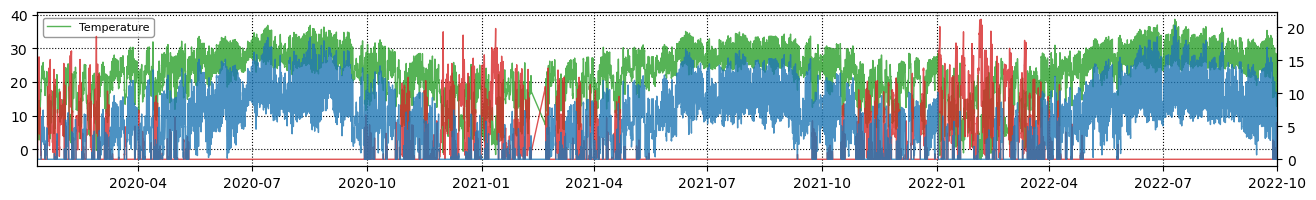

In [5]:
fig, ax = plt.subplots(figsize=(16, 2))
ax.plot(df['temperature_2m'], linewidth=1, c='tab:green', alpha=0.8, label=f'Temperature')
ax1 = ax.twinx()
ax1.plot(df['HDH'], linewidth=1, c='tab:red', alpha=0.8, label=f'HDH')
ax1.plot(df['CDH'], linewidth=1, c='tab:blue', alpha=0.8, label=f'CDH')
ax1.grid(False)

ax.legend(edgecolor='gray', facecolor='white', fontsize=8, loc='upper left')
ax.set_xlim(df.index.min(), df.index.max(), )

#plt.tight_layout()
plt.show()

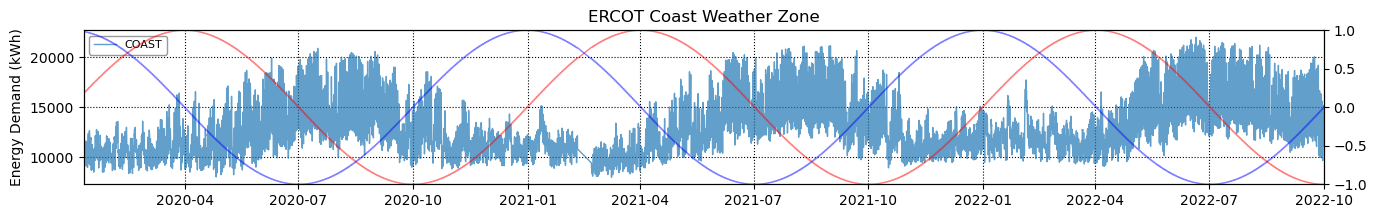

In [6]:
fig, ax = plt.subplots(figsize=(16, 2))

ax.plot(df['COAST'], linewidth=1, c='tab:blue', alpha=0.7, label=f'COAST')

ax1 = ax.twinx()
ax1.plot(df['sin_year'], linewidth=1, c='red', alpha=0.5, )
ax1.plot(df['cos_year'], linewidth=1, c='blue', alpha=0.5, )
ax1.grid(False)
ax1.set_ylim(-1, 1)

ax.legend(edgecolor='gray', facecolor='white', fontsize=8, loc='upper left')
ax.set_xlim(df.index.min(), df.index.max(), )
ax.set_ylabel('Energy Demand (kWh)')
ax.set_title('ERCOT Coast Weather Zone')

plt.show()


In [ ]:
list(df.columns)

In [7]:
with open('features/features_scale.txt', 'r') as f:
    features_to_scale = ast.literal_eval(f.read())

# scale
df_scaled = df.copy()
ss = StandardScaler()
df_scaled[features_to_scale] = ss.fit_transform(df[features_to_scale].values)

# train test split
df_train = df_scaled.loc[:'2022-09-15'].copy()
df_test = df_scaled.loc['2022-09-16':].copy()

fit_models = {}

### Modeling

In [8]:
def gridsearch_fit(model, parameter_grid, X, y):
    """
    Grid Search and return fit model.
    
    Parameters:
        model: Model to search over and fit.
        parameter_grid: Model parameters to search over.
        X: Independent variables (features).
        y: Dependent variable (target).
    Returns: 
        Fit model.
    """
    tss_cv = TimeSeriesSplit(n_splits=5)
    grd = GridSearchCV(
                    model, 
                    param_grid=parameter_grid, 
                    cv=tss_cv, 
                    return_train_score=True, 
                    n_jobs=-1,
                    )
    grd = grd.fit(X, y)
    
    return grd

In [9]:
# ridge
with open('features/features_ln.txt', 'r') as f:
    features = ast.literal_eval(f.read())
    
Xtrain = df_train[features].values
ytrain = df_train['COAST'].values

Xtest = df_test[features].values
ytest = df_test['COAST'].values

parameters = {'alpha':np.arange(0, 200, 0.1)[1:]}

ridge = Ridge()
fit_models['Ridge'] = gridsearch_fit(model=ridge, 
                                   parameter_grid=parameters, 
                                   X=Xtrain, 
                                   y=ytrain,
                                  )

print('Best parameters:', fit_models['Ridge'].best_params_)
print('Best score:', fit_models['Ridge'].best_score_)
df_test[f'ypred_Ridge'] = fit_models['Ridge'].predict(Xtest)

Best parameters: {'alpha': 0.1}
Best score: 0.9910327048790963


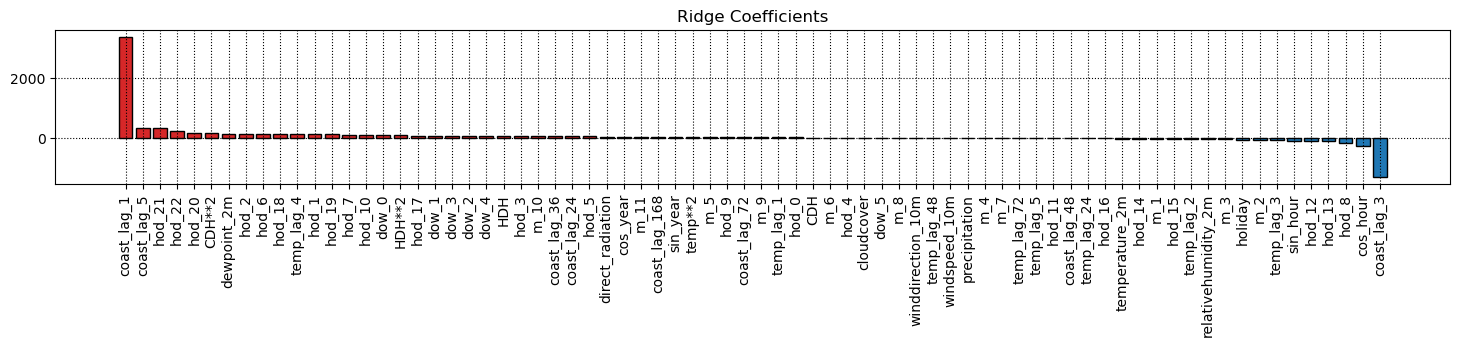

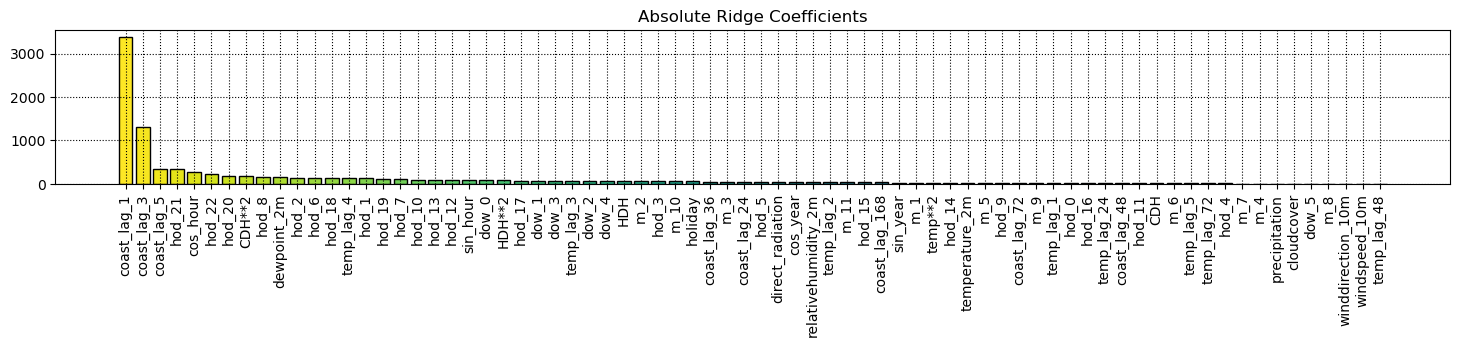

In [10]:
coefs = pd.DataFrame.from_dict(dict(zip(features, fit_models['Ridge'].best_estimator_.coef_)), orient='index')
coefs.columns = ['coefs']
coefs = coefs.sort_values('coefs', ascending=False)
plt.figure(figsize=(18, 2))
plt.bar(coefs.index, coefs['coefs'], color=(coefs['coefs'] > 0).map({False:'tab:blue', True:'tab:red'}), edgecolor='k')
plt.xticks(rotation = 90) 
plt.title('Ridge Coefficients')
plt.show()

abs_coefs = coefs.abs().sort_values('coefs', ascending=False)
colors = [plt.get_cmap('viridis_r')(val/abs_coefs.shape[0]) for val in range(abs_coefs.shape[0])]
plt.figure(figsize=(18, 2))
plt.bar(abs_coefs.index, abs_coefs['coefs'], color=colors, edgecolor='k')
plt.xticks(rotation = 90) 
plt.title('Absolute Ridge Coefficients')
plt.show()

In [11]:
# lasso
with open('features/features_ln.txt', 'r') as f:
    features = ast.literal_eval(f.read())
    
Xtrain = df_train[features].values
ytrain = df_train['COAST'].values

Xtest = df_test[features].values
ytest = df_test['COAST'].values

parameters = {'alpha':np.arange(0, 10, 0.1)[1:]}

lasso = Lasso(max_iter=5000, tol=0.001)
fit_models['LASSO'] = gridsearch_fit(model=lasso, 
                                   parameter_grid=parameters, 
                                   X=Xtrain, 
                                   y=ytrain,
                                  )

print('Best parameters:', fit_models['LASSO'].best_params_)
print('Best score:', fit_models['LASSO'].best_score_)
df_test[f'ypred_LASSO'] = fit_models['LASSO'].predict(Xtest)

Best parameters: {'alpha': 0.1}
Best score: 0.9911031610391587


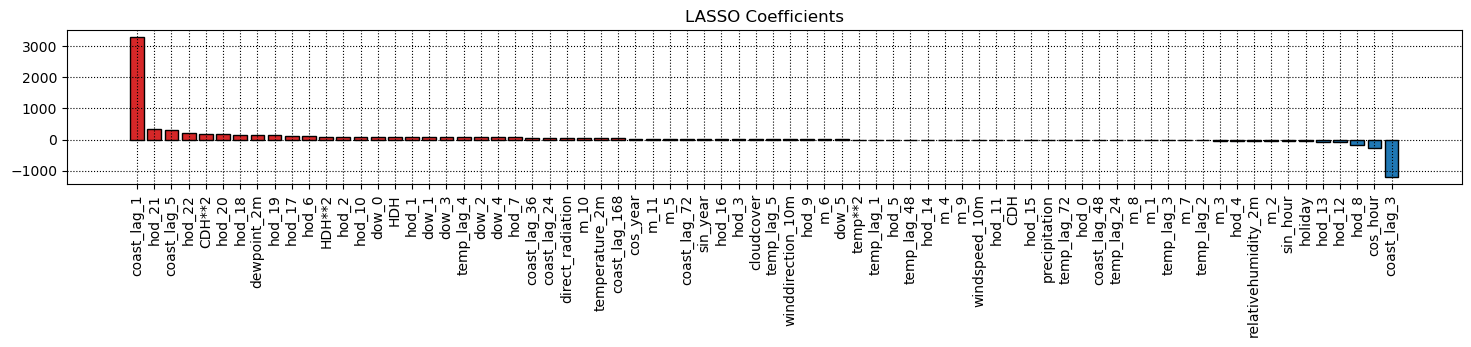

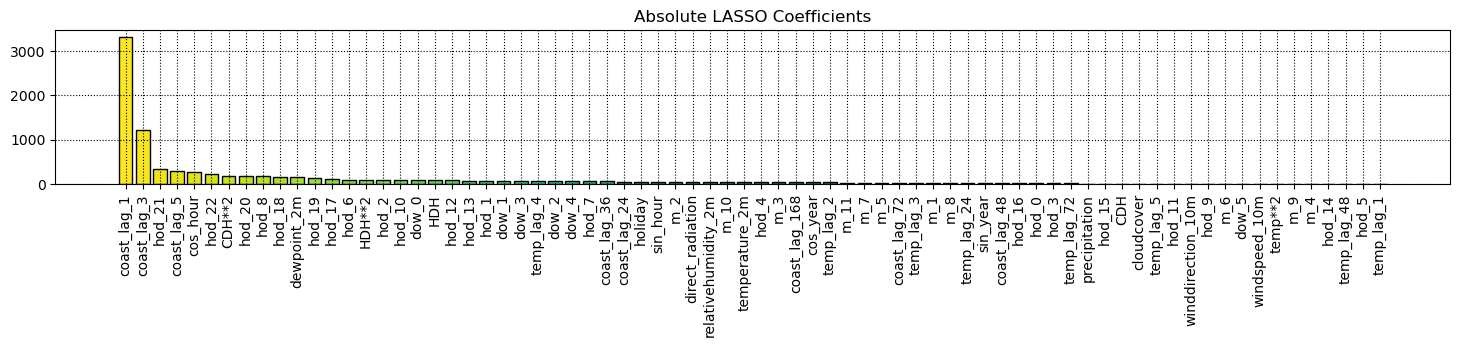

In [12]:
coefs = pd.DataFrame.from_dict(dict(zip(features, fit_models['LASSO'].best_estimator_.coef_)), orient='index')
coefs.columns = ['coefs']
coefs = coefs.sort_values('coefs', ascending=False)
plt.figure(figsize=(18, 2))
plt.bar(coefs.index, coefs['coefs'], color=(coefs['coefs'] > 0).map({False:'tab:blue', True:'tab:red'}), edgecolor='k')
plt.xticks(rotation = 90) 
plt.title('LASSO Coefficients')
plt.show()

abs_coefs = coefs.abs().sort_values('coefs', ascending=False)
colors = [plt.get_cmap('viridis_r')(val/abs_coefs.shape[0]) for val in range(abs_coefs.shape[0])]
plt.figure(figsize=(18, 2))
plt.bar(abs_coefs.index, abs_coefs['coefs'], color=colors, edgecolor='k')
plt.xticks(rotation = 90) 
plt.title('Absolute LASSO Coefficients')
plt.show()

In [13]:
# elastic net
with open('features/features_ln.txt', 'r') as f:
    features = ast.literal_eval(f.read())
    
Xtrain = df_train[features].values
ytrain = df_train['COAST'].values

Xtest = df_test[features].values
ytest = df_test['COAST'].values

parameters = {
                'alpha':np.arange(0, 5, 0.1)[1:],
                'l1_ratio':np.arange(0, 1, 0.05)[1:],
                }
elastic_net = ElasticNet(max_iter=5000, tol=0.01)
fit_models['ElasticNet'] = gridsearch_fit(model=elastic_net, 
                                   parameter_grid=parameters, 
                                   X=Xtrain, 
                                   y=ytrain,
                                  )

print('Best parameters:', fit_models['ElasticNet'].best_params_)
print('Best score:', fit_models['ElasticNet'].best_score_)
df_test[f'ypred_ElasticNet'] = fit_models['ElasticNet'].predict(Xtest)

Best parameters: {'alpha': 0.1, 'l1_ratio': 0.9500000000000001}
Best score: 0.982482804642201


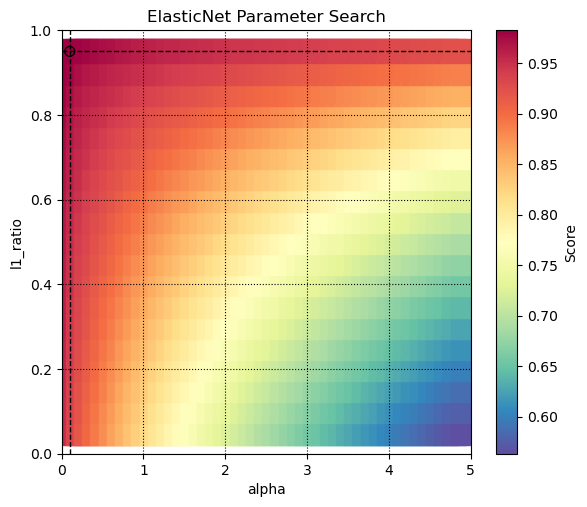

In [21]:
fig, ax = plt.subplots(figsize=(6.6, 5.5))

sc = ax.scatter(
            x=fit_models['ElasticNet'].cv_results_['param_alpha'],
            y=fit_models['ElasticNet'].cv_results_['param_l1_ratio'], 
            c=fit_models['ElasticNet'].cv_results_['mean_test_score'],
            marker='s',
            cmap='Spectral_r',
            s=300,
           )
fig.colorbar(sc, ax=ax, label='Score')
sc = ax.scatter(
            x=fit_models['ElasticNet'].best_params_['alpha'],
            y=fit_models['ElasticNet'].best_params_['l1_ratio'], 
            marker='o',
            facecolors='none',
            edgecolors='k',
            s=50,
           )
ax.axhline(fit_models['ElasticNet'].best_params_['l1_ratio'], color='k', linestyle='--', linewidth=1, label='Best l1_ratio')
ax.axvline(fit_models['ElasticNet'].best_params_['alpha'], color='k', linestyle='--', linewidth=1, label='Best alpha')

ax.set_xlim(0, 5)
ax.set_ylim(0, 1)

ax.set_xlabel("alpha", )
ax.set_ylabel("l1_ratio", )
# plt.legend()
plt.title('ElasticNet Parameter Search')
plt.show()

In [15]:
# GBM
with open('features/features_gbm.txt', 'r') as f:
    features = ast.literal_eval(f.read())
    
Xtrain = df_train[features].values
ytrain = df_train['COAST'].values

Xtest = df_test[features].values
ytest = df_test['COAST'].values

parameters = {
                'learning_rate':np.logspace(-3, 0, 10), 
                'n_estimators':np.arange(200, 800, 100)[1:],
                # 'min_samples_split':[2, 4, 6],
                # 'min_samples_leaf':[1, 3, 5, ],
                'max_depth':[3, 5, 7, 9],
                'max_features':[len(features)//2, 'sqrt'],
             }
parameters = {'learning_rate': [0.04642], 'max_depth': [7], 'n_estimators': [700],  'max_features':[22]}
gbm = GradientBoostingRegressor(random_state=0,
                                )
fit_models['GBM'] = gridsearch_fit(model=gbm, 
                                   parameter_grid=parameters, 
                                   X=Xtrain, 
                                   y=ytrain,
                                  )

print('Best parameters:', fit_models['GBM'].best_params_)
print('Best score:', fit_models['GBM'].best_score_)
df_test[f'ypred_GBM'] = fit_models['GBM'].predict(Xtest)

Best parameters: {'learning_rate': 0.04642, 'max_depth': 7, 'max_features': 22, 'n_estimators': 700}
Best score: 0.9895583973306641


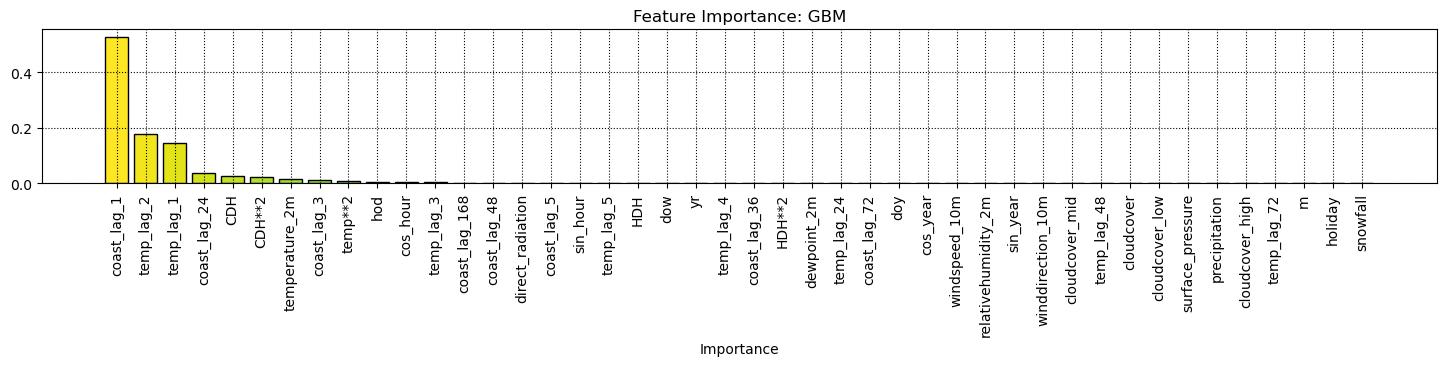

In [16]:
# feature importance
ft_imp = pd.DataFrame(fit_models['GBM'].best_estimator_.feature_importances_)
ft_imp.columns = ['Importance']
ft_imp['Feature'] = features
ft_imp = ft_imp.sort_values('Importance', ascending=False)

cm = plt.cm.get_cmap('viridis_r')
colors = [cm(val/len(features)) for val in range(len(features))]

fig, ax = plt.subplots(figsize=(18, 2))
ax.bar(ft_imp['Feature'], ft_imp['Importance'], edgecolor='k', color=colors)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance: GBM', size=12)
plt.xticks(rotation = 90) 
plt.show()

In [17]:
# SVM
with open('features/features_svm.txt', 'r') as f:
    features = ast.literal_eval(f.read())
    
Xtrain = df_train[features].values
ytrain = df_train['COAST'].values

Xtest = df_test[features].values
ytest = df_test['COAST'].values

parameters = {
            'C':np.logspace(-3, 4, 15),
            'gamma':np.logspace(-3, 4, 15), 
             }
parameters = {'C':[1000], 'gamma':[0.003], }
svm = SVR(kernel='rbf', )

fit_models['SVM'] = gridsearch_fit(model=svm, 
                                   parameter_grid=parameters, 
                                   X=Xtrain, 
                                   y=ytrain,
                                  )

print('Best parameters:', fit_models['SVM'].best_params_)
print('Best score:', fit_models['SVM'].best_score_)
df_test[f'ypred_SVM'] = fit_models['SVM'].predict(Xtest)

Best parameters: {'C': 1000, 'gamma': 0.003}
Best score: 0.9876116862187662


In [ ]:
# fig, ax = plt.subplots(figsize=(6.6, 5.5))

# sc = ax.scatter(
#             x=fit_models['SVM'].cv_results_['param_gamma'],
#             y=fit_models['SVM'].cv_results_['param_C'], 
#             c=fit_models['SVM'].cv_results_['mean_test_score'],
#             marker='s',
#             cmap='Spectral_r',
#             s=300,
#            )
# sc = ax.scatter(
#             x=fit_models['SVM'].best_params_['gamma'],
#             y=fit_models['SVM'].best_params_['C'], 
#             marker='o',
#             facecolors='none',
#             edgecolors='k',
#             s=50,
#            )
# ax.axhline(fit_models['SVM'].best_params_['C'], colooxyoxyr='k', linestyle='--', linewidth=1, label='Best Gamma')
# ax.axvline(fit_models['SVM'].best_params_['gamma'], color='k', linestyle='--', linewidth=1, label='Best C')
# fig.colorbar(sc, ax=ax, label='Score')
# # ax.set_xlim(0, 5)
# # ax.set_ylim(0, 1)

# ax.set_xlabel("Gamma", )
# ax.set_ylabel("C", )
# # plt.legend()
# plt.title('SVM Parameter Search')
# plt.show()

In [18]:
# for m in fit_models:
#     df_test[f'ypred_{m}'] = fit_models[m].predict(Xtest)

r2s = {m:round(metrics.r2_score(df_test['COAST'], df_test[f'ypred_{m}']), 3) for m in fit_models}
rmses = {m:round(np.sqrt(metrics.mean_squared_error(df_test['COAST'], df_test[f'ypred_{m}'])), 3) for m in fit_models}
maes = {m:round(metrics.mean_absolute_error(df_test['COAST'], df_test[f'ypred_{m}']), 3) for m in fit_models}
mapes = {m:round(np.mean(np.abs((df_test['COAST'] - df_test[f'ypred_{m}']) / df_test['COAST'])) * 100, 2) for m in fit_models}

df_metrics = pd.concat([pd.DataFrame.from_dict(met, orient='index') for met in [r2s, rmses, maes, mapes]], axis=1)
df_metrics.columns = ['r2', 'rmse', 'mae', 'mape']
df_metrics

,r2,rmse,mae,mape
Ridge,0.997,141.452,107.305,0.74
LASSO,0.997,141.081,107.362,0.74
ElasticNet,0.996,176.856,137.819,0.95
GBM,0.998,126.497,97.803,0.67
SVM,0.998,127.562,97.620,0.68


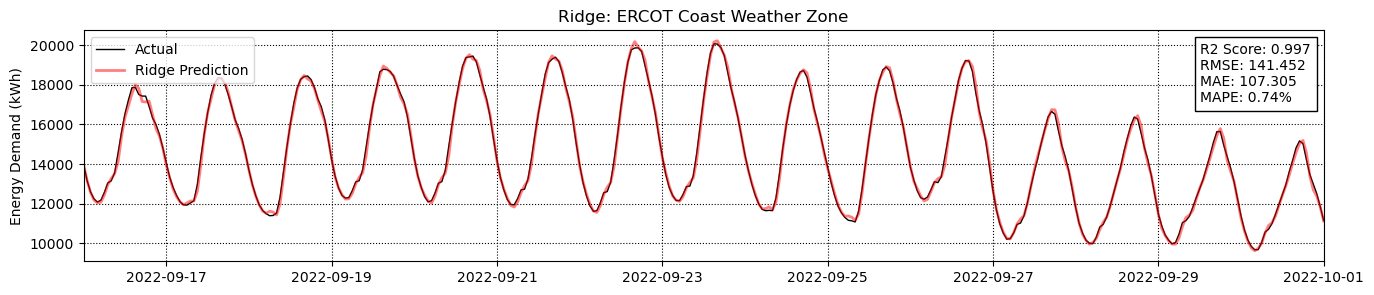

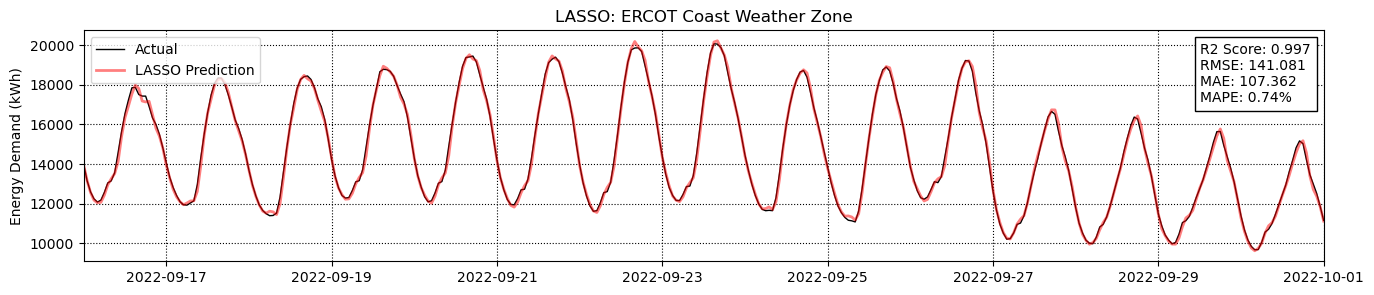

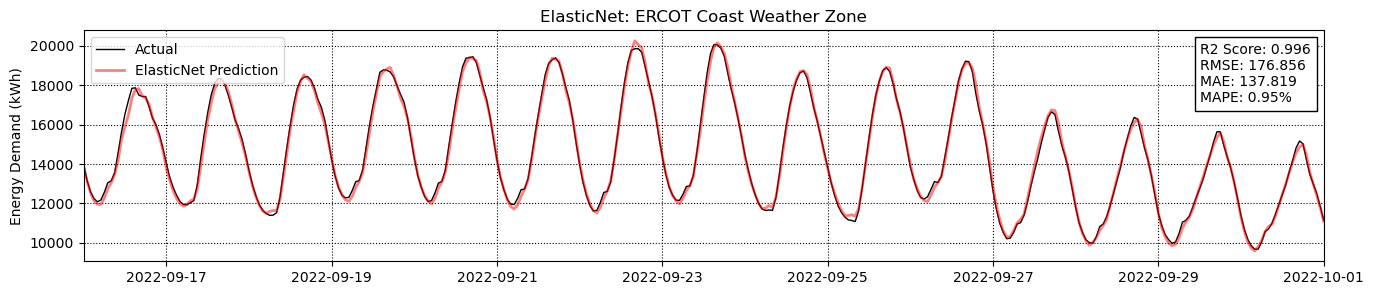

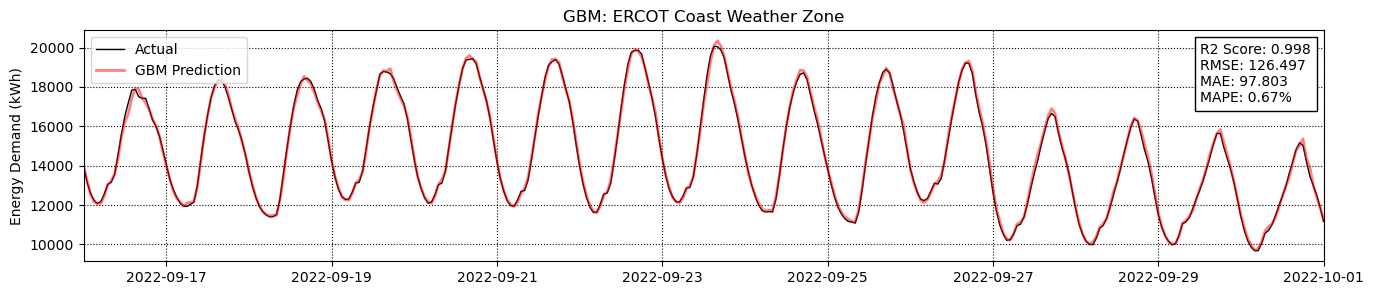

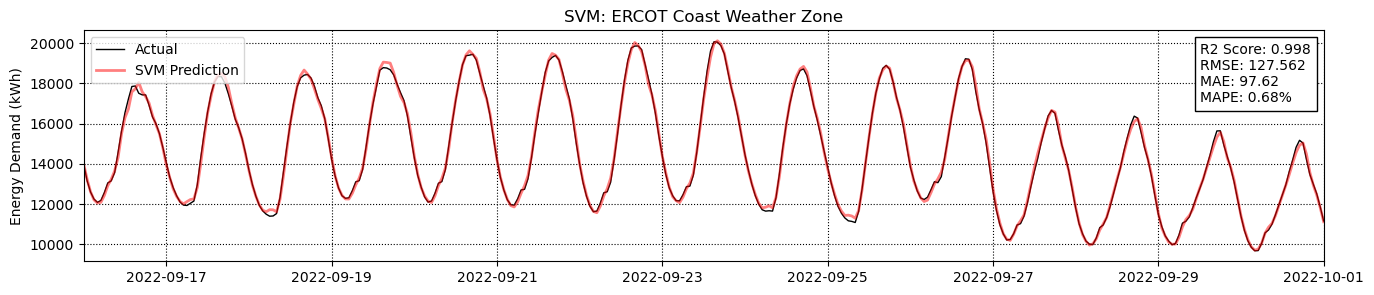

In [19]:
for m in fit_models:
    
    r2 = round(metrics.r2_score(df_test['COAST'], df_test[f'ypred_{m}']), 3)
    rmse = round(np.sqrt(metrics.mean_squared_error(df_test['COAST'], df_test[f'ypred_{m}'])), 3)
    mae = round(metrics.mean_absolute_error(df_test['COAST'], df_test[f'ypred_{m}']), 3)
    mape = round(np.mean(np.abs((df_test['COAST'] - df_test[f'ypred_{m}']) / df_test['COAST'])) * 100, 2)

    fig, ax = plt.subplots(figsize=(16, 3))
    ax.plot(df_test['COAST'], color='k', label='Actual', linewidth=1)
    ax.plot(df_test[f'ypred_{m}'], 'red', label=f'{m} Prediction', linewidth=2, alpha=0.5)

#     ax1 = ax.twinx()
#     ax1.plot(df_test['temperature_2m'], 'green', label='weather', linewidth=1, alpha=0.7)
#     ax1.grid(False)

    anctxt = AnchoredText(f'R2 Score: {r2}\nRMSE: {rmse}\nMAE: {mae}\nMAPE: {mape}%', 
                          loc='upper right', 
                          prop={'fontsize':10}, 
                         )
    ax.add_artist(anctxt, )
    ax.legend(loc='upper left', fontsize=10)
    ax.set_xlim(df_test.index.min(), df_test.index.max(), )
    ax.set_ylabel('Energy Demand (kWh)')
    ax.set_title(f'{m}: ERCOT Coast Weather Zone')
    plt.show()


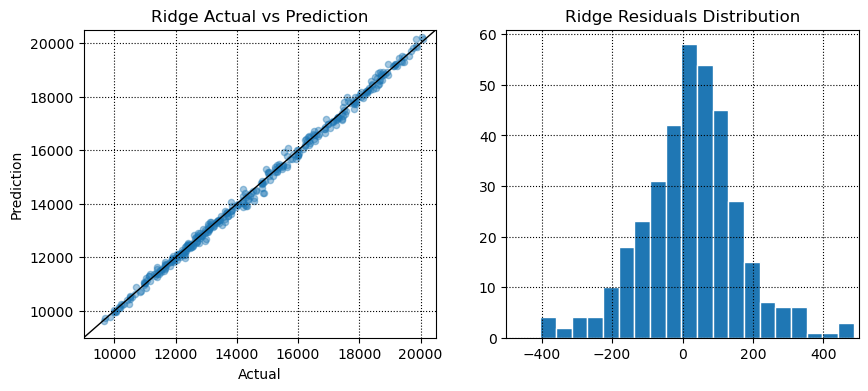

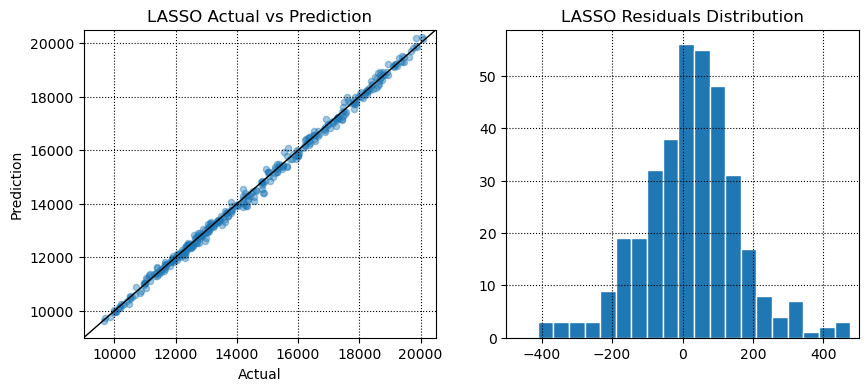

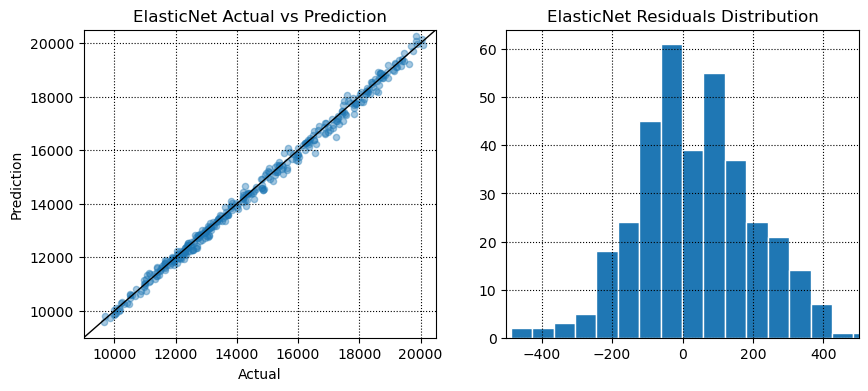

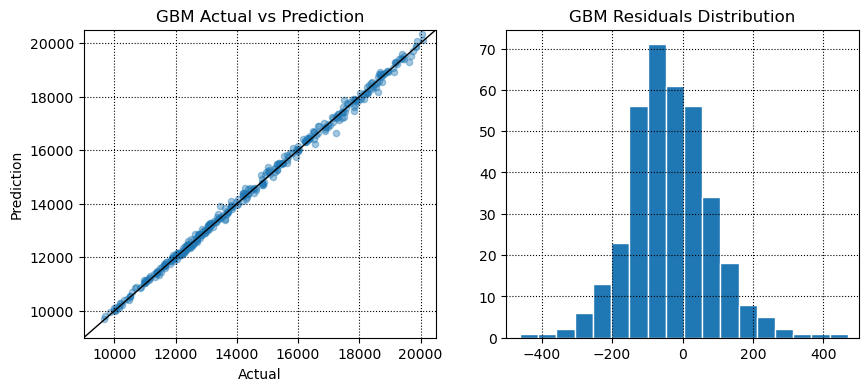

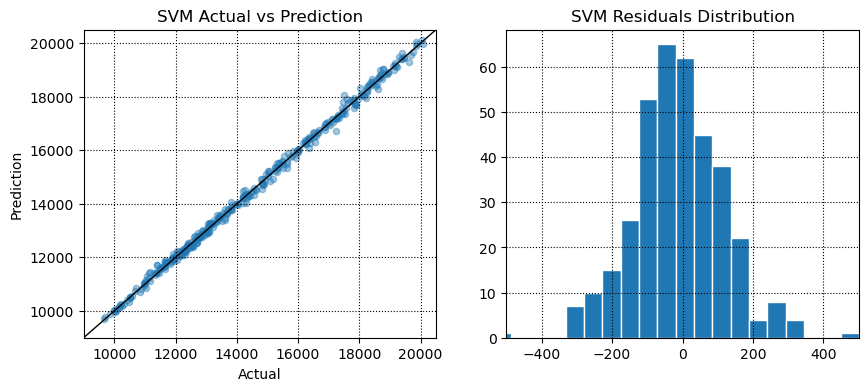

In [20]:

for m in fit_models:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(df_test['COAST'], df_test[f'ypred_{m}'], alpha=0.4, s=20)
    ax[0].plot(range(9000, 20500), range(9000, 20500), color='k', linewidth=1)
    ax[0].set_xlim(9000, 20500)
    ax[0].set_ylim(9000, 20500)
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Prediction')
    ax[0].set_title(f'{m} Actual vs Prediction', size=12)

    ax[1].hist(df_test['COAST'] - df_test[f'ypred_{m}'], bins=20, edgecolor='w')
    ax[1].set_title(f'{m} Residuals Distribution', size=12)
    ax[1].set_xlim(-500, 500)
    
    # ax[2].scatter(df_test['COAST'], df_test['COAST'] - df_test[f'ypred_{m}'], alpha=0.4)
    # ax[2].plot(0, color='k')
    # ax[2].set_xlabel('Actual')
    # ax[2].set_ylabel('Residuals')
    # ax[2].set_title('Actuals vs Residuals', size=16)

    plt.show()